# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
# !wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip

!unzip -q data.zip

--2023-12-07 18:37:48--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-07 18:37:48--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   165MB/s    in 0.2s    

2023-12-07 18:37:48 (165 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
from matplotlib import patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    class_dict_inv = {v: k for k, v in class_dict.items()}
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        name = member.find('name').text
        bbox = member.find('bndbox')
        res = (int(bbox.find('xmin').text),
              int(bbox.find('ymin').text),
              int(bbox.find('xmax').text),
              int(bbox.find('ymax').text),
              class_dict_inv[name])

        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=22):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = np.array(Image.open(fname))
        bboxes = get_xml_data(fname, self.root, self.class_dict_inv)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict_inv)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'orange']

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        # мне кажется что это вообще не эффективный способ денормализовать изображения,
        # но это единственный работающий из того миллиарада способов, что я попробовала...
        for channel in range(3):
          images[i][channel] = images[i][channel] * std[channel] + mean[channel]

        images[i]= images[i].squeeze().permute(1, 2, 0)

        for bbox in bboxes[i]:
          x, y, w, h = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
          label = train_ds.class_dict_inv[bbox[4]]
          color = colors[bbox[4]]
          ax.add_patch(Rectangle((x, y), w, h, edgecolor=color, fill=False))
          ax.text(x, (y - 50), label, verticalalignment='top', color='w', fontsize=10, weight='bold',
                                path_effects=[pe.withStroke(linewidth=3, foreground=color)])

        ax.imshow(images[i])

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

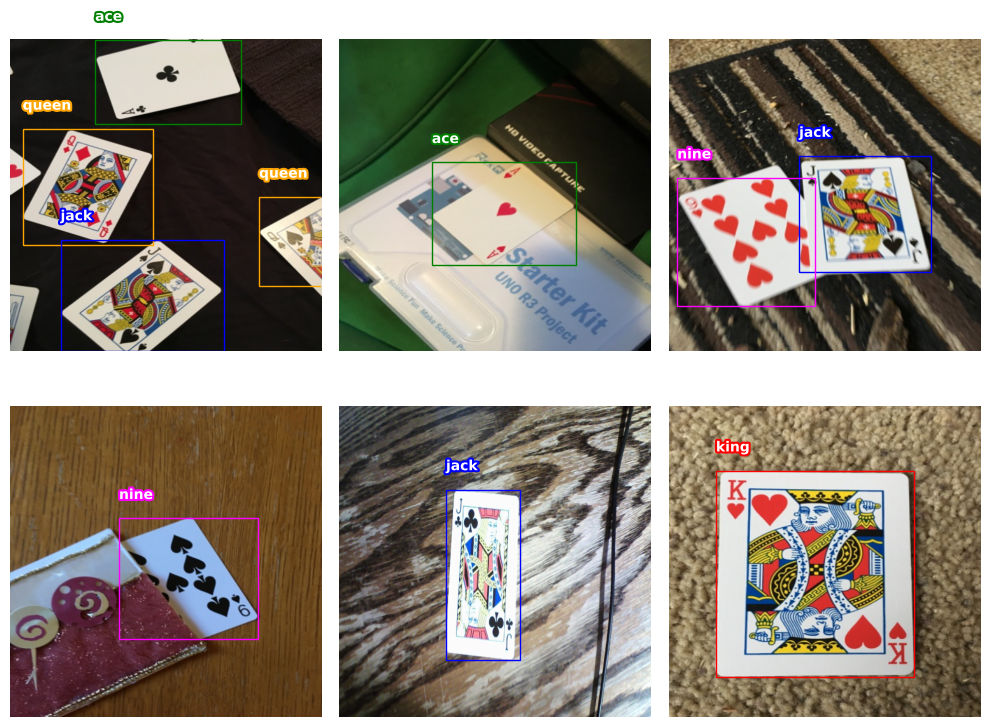

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and width to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [63]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = downsample # размер клетки по X в пикс
        y_cell = downsample # размер клетки по Y в пикс
        w_box = (xmax - xmin) / w # ширина бокса отнормированная
        h_box = (ymax - ymin) / h # высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx = (xmin + xmax) / 2
        cy =  (ymin + ymax) / 2
        cx_idx = (cx / x_cell).to(torch.long) # (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = (cy / y_cell).to(torch.long)

        cx_box = (cx - cx_idx * x_cell) / x_cell # (посчитайте сдивиги относительно cx_idx)
        cy_box = (cy - cy_idx * y_cell) / y_cell

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

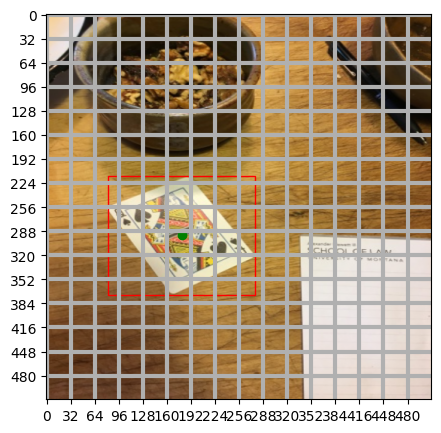

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [64]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    bboxes = []

    for im_idx in range(b): # итерируемся по картинкам
      for cy_idx in range(h):
        for cx_idx in range(w):

          cx, cy, ww, hh, conf, cls = pred[im_idx, :, cy_idx, cx_idx]
          if conf > threshold:
            if c != 6: # если это pred, а не target
              cls = np.argmax(cls)

            # добиваемся формата входа вижуалайза
            xmin = int((cx - (ww / 2)) * img_w)
            ymin = int((cy - (hh / 2)) * img_h)
            xmax = int((cx + (ww / 2)) * img_w)
            ymax = int((cy + (hh / 2)) * img_h)

            bbox = [xmin, ymin, xmax, ymax, int(cls)]
            bboxes.append(bbox)

    return bboxes

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [10]:
C = len(train_ds.class_dict)  # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # https://stackoverflow.com/questions/64631086/how-can-i-add-new-layers-on-pre-trained-model-with-pytorch-keras-example-given
        part1 = nn.Sequential(*list(model.children())[:-2])
        part2 = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + C, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.Sigmoid()
        )
        self.new_model = nn.Sequential(part1, part2)

    def forward(self, img):
        return self.new_model(img)

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [67]:
def special_loss(pred, target, check=False, C=5+6):

  localization_loss = nn.MSELoss(reduction='sum')

  box_loss = nn.MSELoss(reduction='sum')

  classification_loss = nn.CrossEntropyLoss(reduction='sum')

  confidence_loss = nn.BCELoss(reduction='sum')

  print(localization_loss, box_loss, classification_loss, confidence_loss)

  if not check:
      return localization_loss + box_loss + classification_loss + confidence_loss

  else:
      return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=6) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(22)
EPOCHS = 15 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []

    for batch in pbar:
      loss_val = 0.0

      images, labels = batch
      pred = model(images)
      loss = sum(special_loss(pred, labels))
      loss.forward()
      opt.step()
      opt.zero_grad()

      loss_val = float(loss.cpu().detach().numpy()) * len(images)
      epoch_losses.append(loss_val)

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

### YOUR CODE HERE ###

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

### YOUR CODE HERE ###

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 4.7 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
  # https://www.edge-ai-vision.com/2022/04/exploring-data-labeling-and-the-6-different-types-of-image-annotation/
  res = []
  for bbox in bboxes:
    xmin, ymin, xmax, ymax, cls = bbox[0], bbox[1], bbox[2], bbox[3], bbox[4]
    cx = (xmin + xmax) / 2 / w_im
    cy = (ymin + ymax) / 2 / h_im
    w = (xmax - xmin) / w_im
    h = (ymax - ymin) / h_im
    res.append(f'{cls} {cx} {cy} {w} {h}')
  return res

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML
# https://habr.com/ru/articles/714232/

nc = len(train_ds.class_dict) # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(train_ds.class_dict.keys()) # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')
results = model.train(data='data.yaml', epochs=100,  imgsz=512)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 11.3MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 79.0MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 2049.54it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 4 corrupt: 100%|██████████| 37/37 [00:00<00:00, 879.81it/s]

val: WARNING ⚠️ /content/valid/images/cam_image24.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4934]
val: WARNING ⚠️ /content/valid/images/cam_image28.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0185]
val: WARNING ⚠️ /content/valid/images/cam_image39.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1468      1.6349]
val: WARNING ⚠️ /content/valid/images/cam_image54.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1468      1.1005      1.5648]
val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.73G      3.211      4.586      4.393         17        512: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         33         51    0.00122      0.222     0.0022    0.00064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.72G      3.132      4.203      4.141         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         33         51    0.00124      0.222    0.00217   0.000465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.73G      3.026      3.775      3.876         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         33         51    0.00142      0.207    0.00397   0.000588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.73G       2.96      3.485       3.59         28        512: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         33         51    0.00143      0.174    0.00134   0.000175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.72G      2.827      3.429      3.376         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         33         51    0.00234      0.396     0.0117    0.00412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.73G      2.675      3.278      3.226         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         33         51    0.00197      0.314    0.00754    0.00243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.74G      2.569      3.161        3.1         11        512: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

                   all         33         51     0.0396     0.0661     0.0812     0.0339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.74G      2.373      2.979      2.925         28        512: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


                   all         33         51      0.165      0.324      0.178      0.089

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.72G      2.172      2.769      2.739         30        512: 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         33         51      0.273      0.366      0.213      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.73G      2.028      2.632      2.656         31        512: 100%|██████████| 21/21 [00:05<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


                   all         33         51      0.355      0.314      0.306      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.73G      1.871      2.531      2.489         17        512: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         33         51      0.254      0.498      0.302      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.74G      1.762      2.447      2.369         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         33         51      0.249      0.442       0.34      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.72G      1.743      2.404      2.335         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         33         51      0.339      0.672      0.344      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.73G      1.648      2.242      2.238         18        512: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         33         51      0.309       0.53      0.372      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.74G      1.568      2.198      2.165         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         33         51      0.302      0.536      0.329      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.74G      1.521      2.141      2.072         31        512: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         33         51      0.331      0.521      0.383       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.72G      1.466      2.048      2.042         30        512: 100%|██████████| 21/21 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         33         51       0.46      0.693       0.52      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.73G        1.4      1.962      1.969         26        512: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         33         51      0.449      0.627      0.449       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.74G      1.381      1.948      1.966         33        512: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         33         51      0.381       0.64      0.457      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.73G      1.359      1.921      1.951         23        512: 100%|██████████| 21/21 [00:06<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         33         51      0.391      0.769      0.484      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.73G      1.336      1.898      1.914         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         33         51      0.375      0.698      0.518      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.73G      1.273      1.852      1.847         17        512: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         33         51      0.336      0.808      0.492      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.73G      1.267      1.844      1.815         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         33         51      0.318       0.65      0.478      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.76G      1.268      1.816      1.817         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         33         51      0.423      0.722      0.547      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.72G      1.183      1.737      1.752         20        512: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

                   all         33         51       0.42      0.765      0.544      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.73G      1.225      1.743      1.773         18        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         33         51      0.495      0.598      0.546      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.74G      1.184      1.688      1.731         28        512: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         33         51      0.409      0.819      0.528      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.76G      1.198      1.713      1.725         17        512: 100%|██████████| 21/21 [00:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         33         51      0.483       0.66      0.564      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.72G      1.179      1.668      1.723         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         33         51      0.447      0.695      0.524      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.73G      1.129       1.62      1.671         27        512: 100%|██████████| 21/21 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         33         51      0.404      0.711       0.54      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.73G      1.103      1.624      1.659         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         33         51       0.45      0.568      0.582       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.74G      1.125      1.653      1.672         21        512: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         33         51      0.504      0.596      0.625      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.72G       1.06      1.556      1.601         28        512: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         33         51      0.471      0.902      0.604      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.73G      1.042      1.537      1.608         35        512: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


                   all         33         51      0.425      0.895      0.606      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.74G      1.067      1.553      1.595         18        512: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         33         51      0.426      0.845       0.58      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.73G      1.065      1.534      1.601         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         33         51      0.479      0.724      0.609      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.72G      1.005      1.468      1.538         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         33         51      0.481       0.66      0.607      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.74G     0.9547      1.465      1.488         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         33         51       0.41        0.7      0.557      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.73G      1.003      1.489       1.53         27        512: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         33         51      0.393      0.746      0.561      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.73G     0.9366      1.413      1.473         32        512: 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         33         51      0.457      0.831      0.568      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.72G     0.9811      1.441      1.525         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         33         51      0.425      0.869      0.645      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.73G     0.9275      1.406      1.478         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         33         51      0.461      0.813      0.673      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.74G     0.9928       1.44      1.517         20        512: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         33         51      0.518      0.676       0.62      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.73G     0.9516      1.417      1.479         25        512: 100%|██████████| 21/21 [00:05<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         33         51      0.496      0.757      0.682      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.72G     0.9217      1.386      1.482         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         33         51      0.512      0.819      0.672      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.73G     0.9501      1.378      1.468         33        512: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         33         51      0.522      0.799      0.677      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.74G     0.9202      1.383      1.458         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

                   all         33         51      0.536      0.849      0.692      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.73G     0.8949      1.329      1.434         33        512: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         33         51      0.467      0.851      0.665      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.73G     0.9443      1.366      1.469         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         33         51      0.618      0.627      0.663      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.73G     0.8857      1.351       1.43         11        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         33         51      0.564      0.734      0.693      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.73G     0.8993      1.308      1.446         23        512: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         33         51      0.574      0.813      0.728      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.72G     0.8893      1.283      1.426         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

                   all         33         51      0.654       0.79      0.748      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.73G     0.8814      1.269      1.414         23        512: 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         33         51       0.66      0.642      0.732      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.74G     0.8421      1.225       1.38         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         33         51      0.559      0.895      0.782      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.74G     0.8365      1.235      1.365         14        512: 100%|██████████| 21/21 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


                   all         33         51      0.566       0.69      0.704      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.73G     0.8537      1.234      1.397         18        512: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         33         51      0.564      0.834      0.697      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.72G     0.8427      1.199      1.398         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         33         51      0.555      0.858      0.637      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.74G     0.8287      1.183       1.37         29        512: 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         33         51      0.629      0.859      0.726      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.73G     0.8231      1.171      1.373         30        512: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         33         51      0.642      0.773      0.764      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.74G     0.8367      1.177      1.363         27        512: 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         33         51      0.597      0.802      0.765      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.72G     0.8319      1.135      1.359         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         33         51      0.614      0.762      0.743      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.73G     0.8105      1.155      1.348         33        512: 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


                   all         33         51      0.672      0.775      0.799      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.74G     0.8275      1.174      1.384         20        512: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         33         51      0.625      0.897      0.787      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.73G     0.7792      1.185      1.329         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         33         51      0.529      0.853      0.739      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.75G     0.7909      1.198      1.348         26        512: 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         33         51      0.698      0.794      0.768      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.74G     0.7807      1.121       1.33         32        512: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         33         51      0.609      0.821      0.765      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.74G       0.79      1.142      1.323         15        512: 100%|██████████| 21/21 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         33         51      0.614      0.898      0.761      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.73G     0.7633      1.097      1.317         28        512: 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         33         51      0.606       0.85      0.765      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.72G     0.7678      1.101      1.321         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         33         51      0.638      0.907      0.795       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.72G     0.7774      1.094      1.319         43        512: 100%|██████████| 21/21 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         33         51      0.696      0.865      0.816      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.73G     0.7648      1.082       1.31         31        512: 100%|██████████| 21/21 [00:04<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         33         51      0.552      0.874      0.788      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.73G     0.7725      1.078      1.309         25        512: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         33         51      0.612      0.762      0.762      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.72G     0.7633      1.085      1.298         17        512: 100%|██████████| 21/21 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         33         51      0.633      0.874      0.836      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.73G     0.7413      1.029      1.288         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         33         51      0.864      0.767      0.889      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.73G      0.779      1.102      1.327         28        512: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         33         51      0.768      0.841      0.872      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.73G     0.7507      1.055      1.297         36        512: 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         33         51      0.724      0.792      0.822       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.73G      0.737      1.012      1.278         32        512: 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         33         51      0.744      0.825      0.819      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.73G     0.7542       1.02      1.297         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         33         51      0.725       0.82      0.837      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.73G     0.7484      1.024      1.293         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


                   all         33         51       0.74      0.774      0.852      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.73G     0.7128      0.992      1.257         34        512: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         33         51      0.713      0.842      0.852      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.73G      0.771      1.054      1.304         34        512: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         33         51      0.742      0.816      0.836      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.73G     0.7181     0.9845      1.267         36        512: 100%|██████████| 21/21 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         33         51      0.684      0.886      0.831      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.73G     0.7359     0.9825      1.274         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         33         51      0.713       0.88      0.833      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.74G     0.6965     0.9433      1.245         24        512: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         33         51      0.662      0.837      0.828      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.72G     0.6936     0.9441      1.238         32        512: 100%|██████████| 21/21 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         33         51      0.632      0.837      0.818      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.73G     0.7451      1.009      1.294         17        512: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         33         51      0.721       0.78       0.84      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.73G     0.7262     0.9938      1.281         25        512: 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         33         51      0.665      0.814      0.807      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.73G     0.6915     0.9453      1.244         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         33         51      0.636      0.868      0.809      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.71G     0.6873     0.9365      1.228         15        512: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         33         51      0.631      0.908      0.839      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.73G     0.7081      0.957      1.259         19        512: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         33         51      0.735      0.864      0.849      0.758


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.72G     0.5589      0.852      1.136         15        512: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         33         51      0.675      0.909      0.835      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.72G      0.553     0.8184      1.131         13        512: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         33         51      0.762      0.805      0.839      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.71G      0.539     0.7645      1.112         12        512: 100%|██████████| 21/21 [00:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         33         51       0.83      0.789      0.851      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.72G     0.5291     0.7331      1.112         15        512: 100%|██████████| 21/21 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         33         51      0.787      0.816      0.854      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.72G     0.5355     0.7684      1.112          9        512: 100%|██████████| 21/21 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


                   all         33         51      0.784       0.85      0.861      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.72G     0.5134     0.7164      1.109         11        512: 100%|██████████| 21/21 [00:05<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         33         51      0.737      0.894      0.869      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.71G      0.516     0.7019      1.089         14        512: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         33         51      0.793      0.857      0.854      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.72G     0.5245     0.7308      1.114         11        512: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         33         51      0.786      0.818      0.852      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.72G     0.5006     0.6987      1.105         17        512: 100%|██████████| 21/21 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         33         51      0.886        0.8      0.877      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.72G     0.5207     0.6763      1.096         10        512: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         33         51       0.84      0.845      0.884      0.796



100 epochs completed in 0.182 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


                   all         33         51       0.84      0.846      0.884      0.796
                  king         33          9      0.929      0.889      0.984      0.865
                  jack         33          6          1      0.763      0.942      0.911
                   ace         33          7      0.774      0.981      0.902      0.763
                   ten         33         11      0.813      0.909      0.824      0.743
                  nine         33         11      0.751      0.821      0.812      0.771
                 queen         33          7      0.771      0.714      0.837      0.723
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/train


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
trained_model = YOLO('/content/runs/detect/train/weights/best.pt')
predictions = trained_model.predict(test_ds.filenames, save=True)


0: 512x512 1 jack, 1: 512x512 1 jack, 1 queen, 2: 512x512 1 queen, 3: 512x512 1 jack, 1 ace, 1 ten, 2 nines, 4: 512x512 1 ten, 5: 512x512 1 ace, 2 tens, 1 nine, 6: 512x512 1 king, 1 jack, 1 queen, 7: 512x512 1 king, 1 jack, 1 nine, 8: 512x512 1 ten, 2 nines, 9: 512x512 1 jack, 10: 512x512 1 king, 1 ten, 1 queen, 11: 512x512 1 ten, 12: 512x512 1 ten, 1 nine, 13: 512x512 1 king, 14: 512x512 1 nine, 15: 512x512 1 king, 1 ace, 2 tens, 1 nine, 16: 512x512 1 nine, 17: 512x512 1 nine, 18: 512x512 1 king, 19: 512x512 1 king, 20: 512x512 1 nine, 21: 512x512 1 jack, 1 queen, 22: 512x512 1 jack, 1 queen, 23: 512x512 1 ace, 24: 512x512 1 king, 25: 512x512 1 king, 2 aces, 1 ten, 1 queen, 26: 512x512 1 ten, 1 nine, 2 queens, 27: 512x512 1 ace, 1 ten, 28: 512x512 1 king, 1 ace, 29: 512x512 1 king, 1 ace, 30: 512x512 1 ace, 31: 512x512 1 jack, 32: 512x512 1 queen, 33: 512x512 1 ten, 34: 512x512 1 ten, 2 nines, 35: 512x512 1 king, 1 ace, 1 ten, 36: 512x512 1 king, 1 ten, 1 queen, 131.2ms
Speed: 4.0ms 

In [ ]:
def plot_random_images(path, n):
  images = [f for f in glob.glob(path)]
  random.shuffle(images)
  fig, axes = plt.subplots(2, n // 2 + n % 2, figsize=(14, 12), dpi=100)

  for i, ax in enumerate(axes.reshape(-1)):
        ax.axis(False)
        if i >= len(images):
            break
        image = plt.imread(images[i])
        ax.imshow(image)

  fig.tight_layout()
  plt.show()

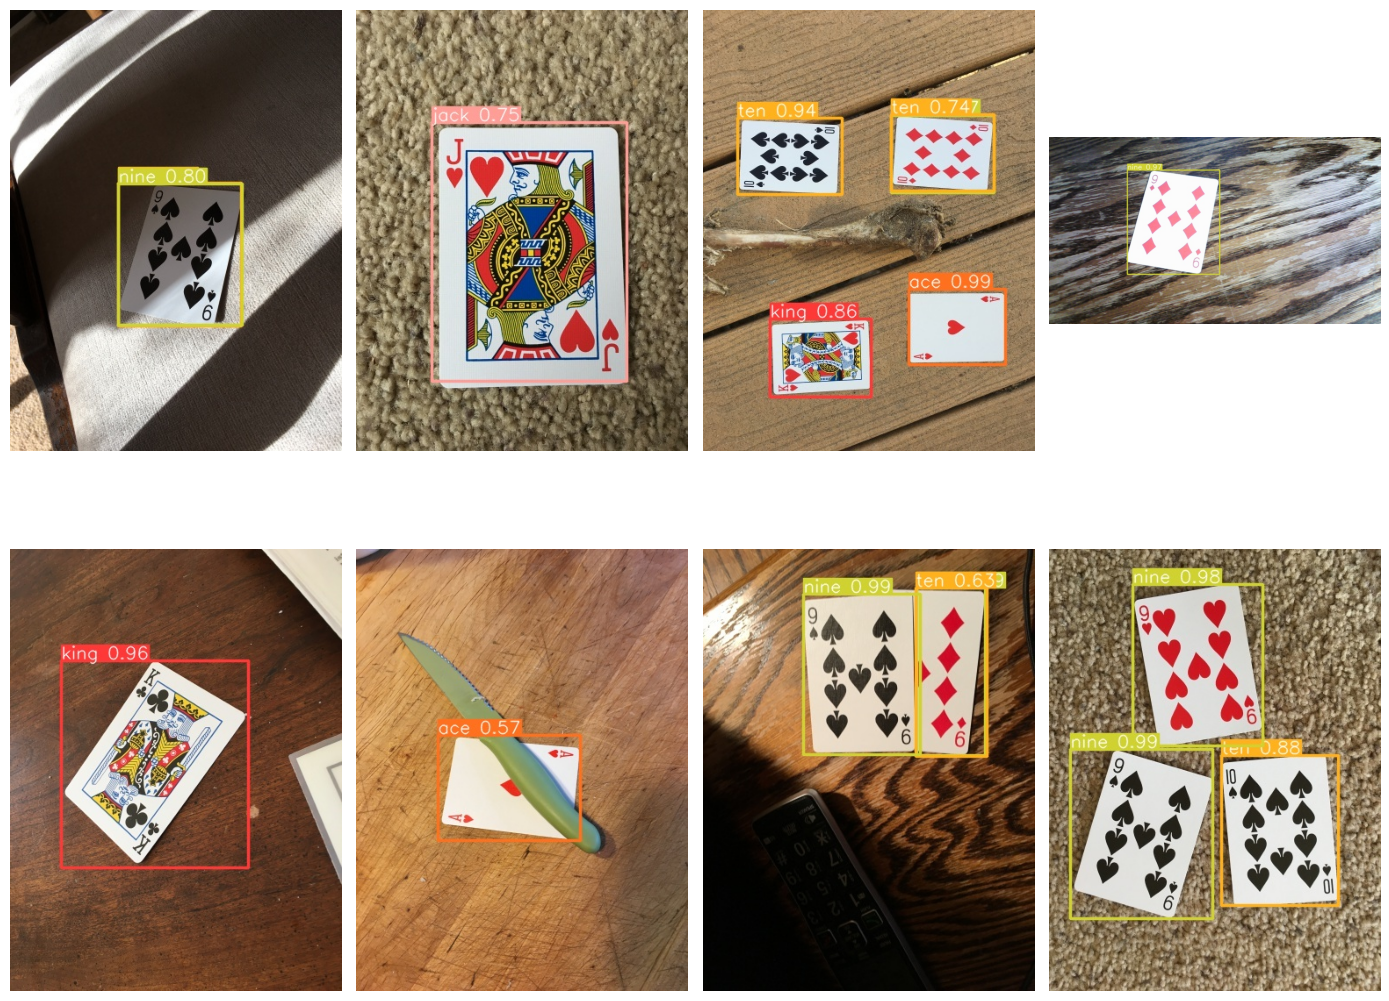

In [ ]:
path = '/content/runs/detect/predict/*'
plot_random_images(path, 8)